In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
from scipy import stats
import seaborn as sns

from matplotlib import rcParams
from pymc3 import Exponential, StudentT, Deterministic, Uniform, Lognormal

# figure size in inches
rcParams['figure.figsize'] = 10, 6

In [2]:
ann_fac = np.sqrt(12)
returns_data = np.array([0.01, -0.02, 0.015, 0.02, 0.01, -0.005, 0.01, 0.01, 0.025, 0.0125, -0.05, 0.06])

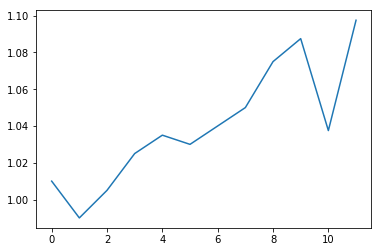

In [3]:
plt.plot(1+np.cumsum(returns_data));

In [4]:
np.mean(returns_data)/np.std(returns_data)*ann_fac

1.1229125711679635

In [5]:
with pm.Model() as model:
    mean_return = pm.Normal('mean return', mu=0.0, sd=0.015)
    volatility = pm.Gamma('volatility', mu=.015, sd=0.015)

    obs = pm.Normal(
        'returns', 
        mu=mean_return, 
        sd=volatility,
        observed=returns_data
    )
    
    sharpe = pm.Deterministic(
        'sharpe ratio', 
        (mean_return / volatility) * ann_fac
    )


In [6]:
with model:
    step = pm.NUTS()
    trace = pm.sample(5000, step)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [volatility, mean return]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:04<00:00, 4756.69draws/s]


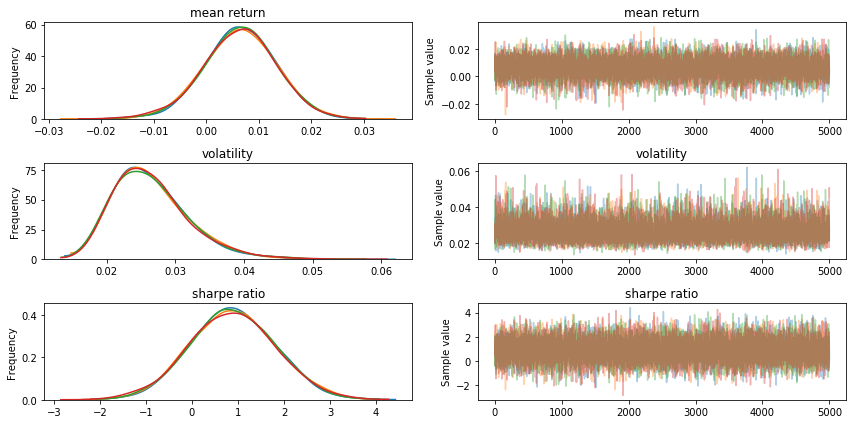

In [7]:
pm.traceplot(trace);

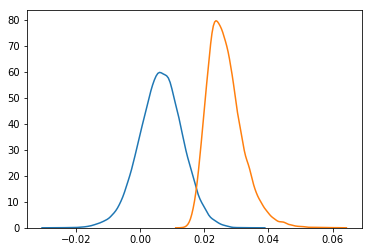

In [8]:
sns.distplot(trace['mean return'], hist=False);
sns.distplot(trace['volatility'], hist=False);

In [9]:
ann_fac*trace['mean return'].mean()/trace['volatility'].mean()

0.8390506628064273

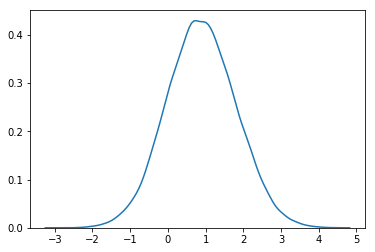

In [10]:
sns.distplot(trace['sharpe ratio'], hist=False);

In [11]:
# You can ask statistically meaningful questions
print('P(Sharpe Ratio > 1) = %.2f%%' % (np.mean(trace['sharpe ratio'] > 1) * 100))


P(Sharpe Ratio > 1) = 44.87%


In [12]:
# gives similar results as frequentist at this point, but we have *confidence* now

In [13]:
# is this a good model?

In [14]:
#check model: posterior predicitive checks
ppc = pm.sample_ppc(trace, samples=500, model=model)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
100%|██████████| 500/500 [00:00<00:00, 643.32it/s]


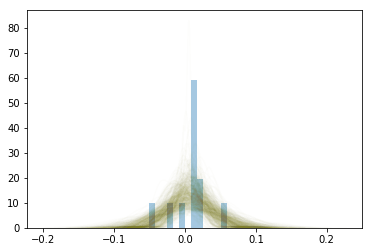

In [15]:
sns.distplot(returns_data, kde=False, norm_hist=True);
for p in ppc['returns']:
    sns.distplot(p, hist=False, kde_kws={'color': 'olive', 'alpha':0.01}, norm_hist=True);

In [16]:
with pm.Model() as t_model:
    # Priors on Random Variables
    mean_return = pm.Normal('mean return', mu=0.0, sd=1)
    volatility = pm.Gamma('volatility', mu=.015, sd=2)
    tail = Uniform('tail', lower=1, upper=10)


    # Model returns as Normal
    obs = pm.StudentT(
        'returns', 
        mu=mean_return, 
        sd=volatility,
        nu=tail,
        observed=returns_data
    )
    
    sharpe = pm.Deterministic(
        'sharpe ratio', 
        (mean_return / volatility) * ann_fac
    )

In [17]:
with t_model:
    # Instantiate MCMC sampler
    step = pm.NUTS()
    # Draw 500 samples from the posterior
    trace_t = pm.sample(5000, step)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tail, volatility, mean return]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:09<00:00, 2261.86draws/s]


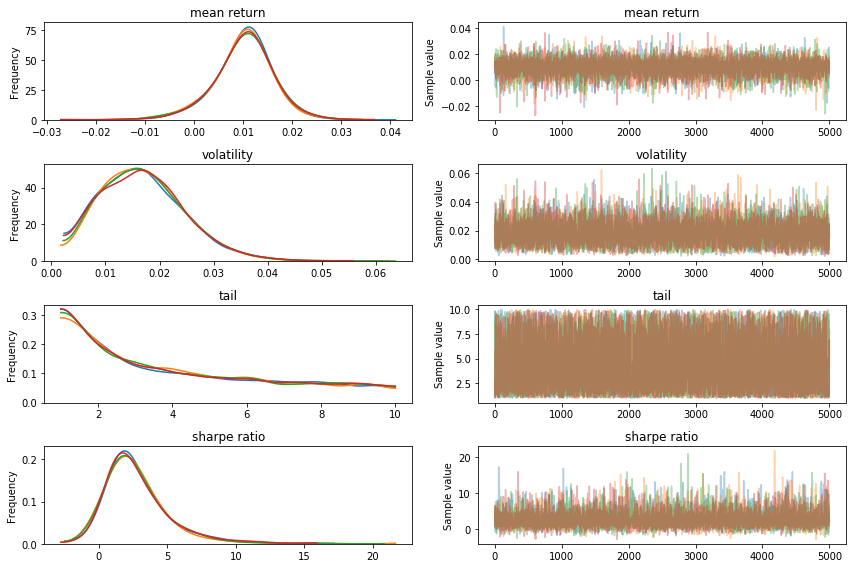

In [18]:
pm.traceplot(trace_t);

In [19]:
ppc_t = pm.sample_ppc(trace_t, samples=500, model=model)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """Entry point for launching an IPython kernel.
100%|██████████| 500/500 [00:00<00:00, 2463.41it/s]


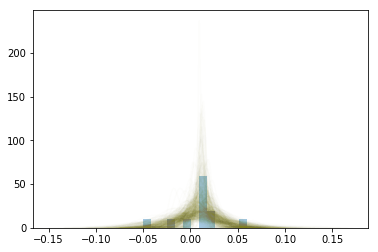

In [20]:
sns.distplot(returns_data, kde=False, norm_hist=True);
for p in ppc_t['returns']:
    sns.distplot(p, hist=False, kde_kws={'color': 'olive', 'alpha':0.01}, norm_hist=True);

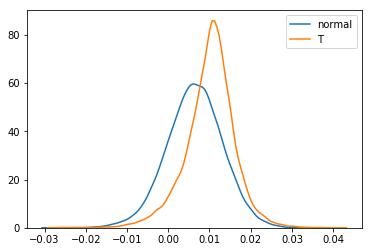

In [21]:
sns.distplot(trace['mean return'], hist=False, label='normal');
sns.distplot(trace_t['mean return'], hist=False, label='T');

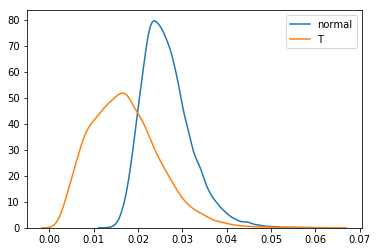

In [22]:
sns.distplot(trace['volatility'], hist=False, label='normal');
sns.distplot(trace_t['volatility'], hist=False, label='T');

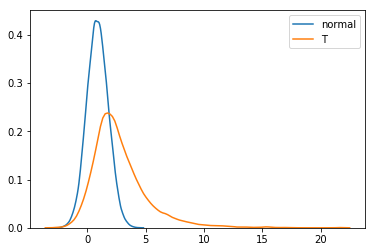

In [23]:
sns.distplot(trace['sharpe ratio'], hist=False, label='normal');
sns.distplot(trace_t['sharpe ratio'], hist=False, label='T');

In [145]:
ann_fac*trace_t['mean return'].mean()/trace_t['volatility'].mean()

2.099809386204199

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


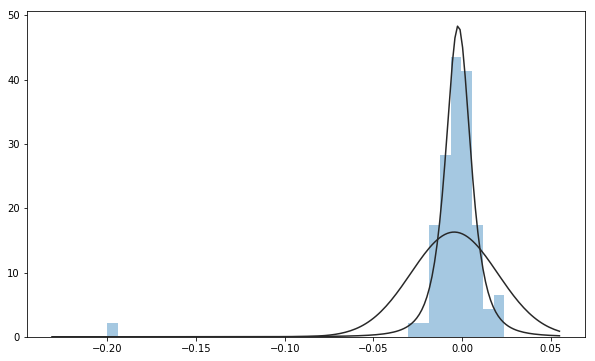

In [157]:
sim_data = list(np.random.randn(75)*0.01)
sim_data.append(-0.2)
sns.distplot(sim_data, label='normal', kde=False, norm_hist=True, fit=stats.norm);
sns.distplot(sim_data, label='normal', kde=False, hist=False, norm_hist=True, fit=stats.t, color='r');



# Bayesian Track Record Measurement
- framework
- Bayesian vs frequentist confidence interval

In [24]:
import pandas as pd

In [25]:
# load benchmark
benchmark = pd.read_csv('index-ror-perf-download-2279_1532625973.csv', index_col=0,parse_dates=True)
benchmark.iloc[:, 0] = benchmark.iloc[:, 0].str.rstrip('%').astype('float') / 100.0

FileNotFoundError: File b'index-ror-perf-download-2279_1532625973.csv' does not exist

In [ ]:
(1+benchmark).cumprod().plot();

In [ ]:
st_returns = benchmark.values[-12:]

with pm.Model() as model_st:
    mean_return = pm.Normal('mean return', mu=0.005, sd=0.005)
    volatility = pm.Gamma('volatility', mu=.015, sd=0.015)

    obs = pm.Normal(
        'returns', 
        mu=mean_return, 
        sd=volatility,
        observed=st_returns
    )
    
    sharpe = pm.Deterministic(
        'sharpe ratio', 
        (mean_return / volatility) * ann_fac
    )


In [ ]:
with model_st:
    step = pm.NUTS()
    trace_st = pm.sample(5000, step)

In [222]:
lt_returns = benchmark.values[-60:]

with pm.Model() as model_lt:
    mean_return = pm.Normal('mean return', mu=0.0, sd=0.015)
    volatility = pm.Gamma('volatility', mu=.015, sd=0.015)

    obs = pm.Normal(
        'returns', 
        mu=mean_return, 
        sd=volatility,
        observed=lt_returns
    )
    
    sharpe = pm.Deterministic(
        'sharpe ratio', 
        (mean_return / volatility) * ann_fac
    )


In [223]:
with model_lt:
    step = pm.NUTS()
    trace_lt = pm.sample(5000, step)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [volatility, mean return]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:05<00:00, 4377.21draws/s]


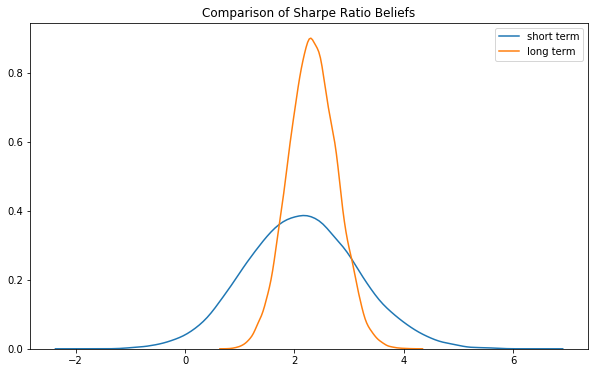

In [237]:
sns.distplot(trace_st['sharpe ratio'], hist=False, label='short term');
sns.distplot(trace_lt['sharpe ratio'], hist=False, label='long term');
plt.title('Comparison of Sharpe Ratio Beliefs');

In [219]:
ppc_lt = pm.sample_ppc(trace_lt, samples=500, model=model)

100%|██████████| 500/500 [00:00<00:00, 932.49it/s]


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


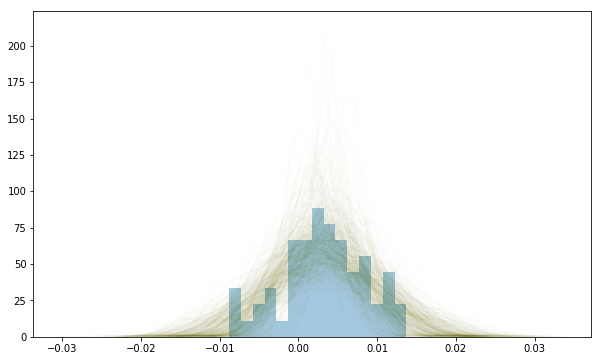

In [228]:
sns.distplot(lt_returns, kde=False, norm_hist=True, bins=15);
for p in ppc_lt['returns']:
    sns.distplot(p, hist=False, kde_kws={'color': 'olive', 'alpha':0.01}, norm_hist=True);

In [269]:
12*0.005/0.02

3.0

In [287]:


with pm.Model() as model_lt_IR:
    excess_returns = pm.Normal('mean return', mu=0.0, sd=0.015)
    tracking_error = pm.Gamma('volatility', mu=.015, sd=0.015)

    obs = pm.Normal(
        'returns', 
        mu=excess_returns, 
        sd=tracking_error,
        observed=hf_returns-bench_returns
    )
    
    sharpe = pm.Deterministic(
        'IR', 
        (excess_returns / tracking_error) * ann_fac
    )


In [271]:
with model_lt_IR:
    step = pm.NUTS()
    trace_lt_IR = pm.sample(5000, step)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [volatility, mean return]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:05<00:00, 3951.71draws/s]


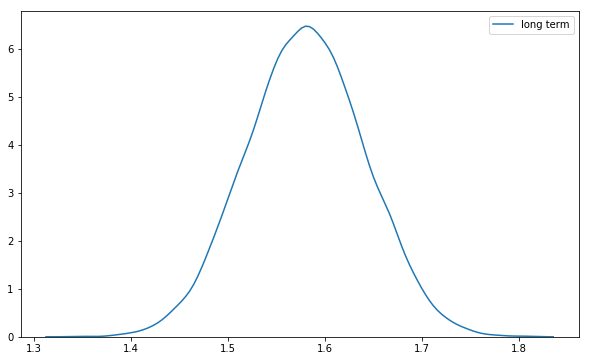

In [272]:
sns.distplot(trace_lt_IR['IR'], hist=False, label='long term');

In [397]:
history_months = 60

In [408]:
benchmark

,Monthly Rate of Return,fund
Date,,
1990-01-01,0.0123,-0.010461
1990-02-01,0.0123,0.029534
1990-03-01,0.0082,0.008813
1990-04-01,0.0073,0.014234
1990-05-01,0.0050,0.016755
1990-06-01,0.0137,0.007813
1990-07-01,0.0077,0.016258
1990-08-01,0.0180,0.015795
1990-09-01,0.0181,0.015441


In [416]:
df = benchmark
df.columns

Index(['benchmark', 'fund'], dtype='object')

In [418]:
df['fund'] = (np.ravel(benchmark.iloc[:,0].values) + np.random.normal(loc=0.004, scale=0.015, size=len(benchmark)))
df.columns = ['benchmark', 'fund']


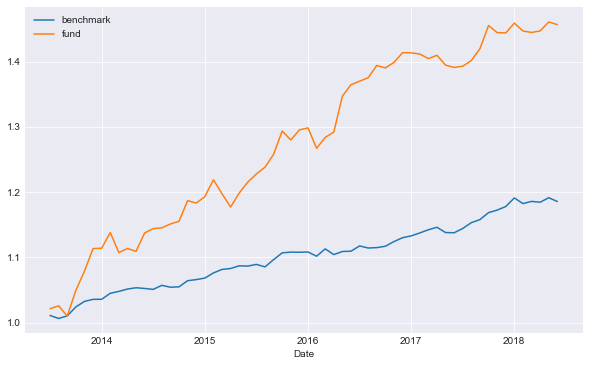

In [419]:
(1+df.iloc[-history_months:,].cumsum()).plot()

In [402]:
ann_fac*0.004/0.015

0.9237604307034012

In [386]:
df.head()

,Monthly Rate of Return,fund
Date,,
1990-01-01,0.0123,0.021457
1990-02-01,0.0123,0.010783
1990-03-01,0.0082,0.018072
1990-04-01,0.0073,0.009725
1990-05-01,0.0050,0.016140


$$fund \sim N(\alpha + \beta * r_b, \sigma_{TE})$$


$$benchmark \sim N(r_b, \sigma_b)$$

$$r_b \sim N(\mu_b, \sigma_{r_b})$$
$$\sigma_b \sim HC(\beta_{\sigma_b})$$

$$\alpha \sim N(\mu_{\alpha}, \sigma_{\alpha})$$
$$\beta \sim N(\mu_{\beta}, \sigma_{\beta})$$
$$\sigma_{TE} \sim HC(\beta_{\sigma_{TE}})$$


In [429]:
with pm.Model() as model_lr:

    alpha = pm.Normal('alpha', mu=0.0, sd=0.025)
    beta = pm.Normal('beta', mu=1, sd=0.25)
    te = pm.HalfCauchy('te', beta=5)
    bench_er = pm.Normal('bench_er', mu=0.003, sd=0.025)
    bench_vol = pm.HalfCauchy('bench_vol', beta=5)

    hf_model = pm.Normal(
        'fund',
        mu=alpha+beta*bench_er,
        sd=te,
        observed=df.iloc[-history_months:, 1]
    )

    benchmark_model = pm.Normal(
        'benchmark',
        mu=bench_er,
        sd=bench_vol,
        observed=df.iloc[-history_months:, 0]
    )

    sharpe = pm.Deterministic('IR', (alpha/te)*ann_fac)

    trace_lr = pm.sample(10000, tune=1000) # draw posterior samples

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bench_vol, bench_er, te, beta, alpha]
Sampling 4 chains: 100%|██████████| 44000/44000 [00:16<00:00, 2617.94draws/s]


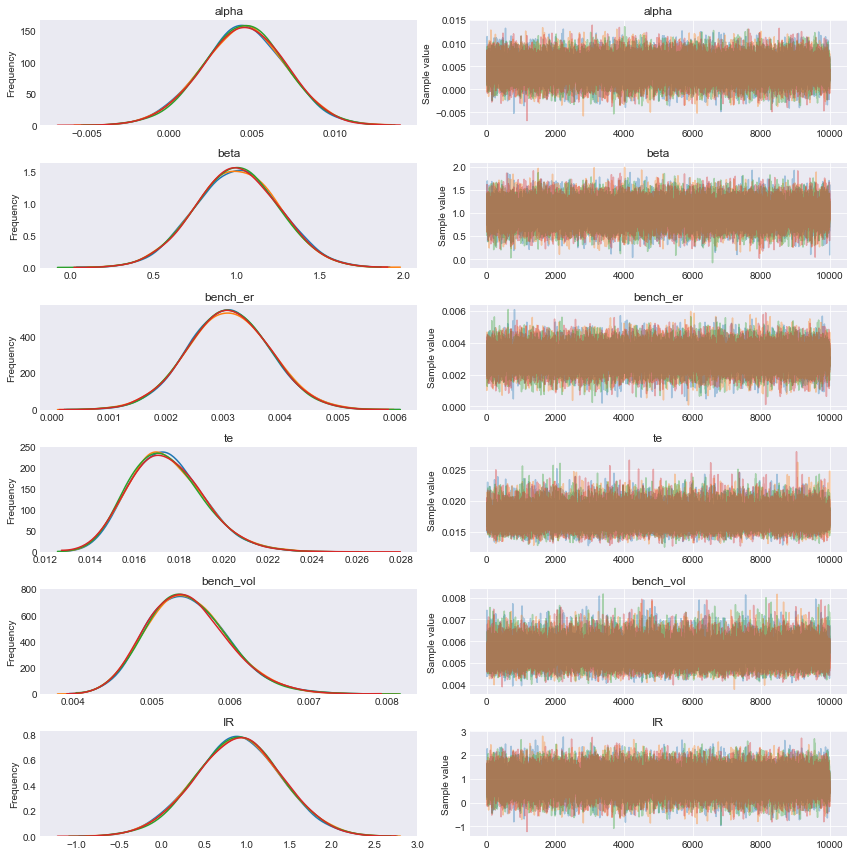

In [430]:
pm.traceplot(trace_lr);

In [431]:
from pymc3 import find_MAP, hpd

In [432]:
map_estimate = find_MAP(model=model_lr)

logp = 386.82, ||grad|| = 478.57: 100%|██████████| 41/41 [00:00<00:00, 1873.50it/s]   


In [435]:
print(map_estimate)

{'alpha': array(0.00447957), 'beta': array(1.00031185), 'te_log__': array(-4.07937375), 'bench_er': array(0.00309496), 'bench_vol_log__': array(-5.23873678), 'te': array(0.01691806), 'bench_vol': array(0.00530696), 'IR': array(0.91722612)}


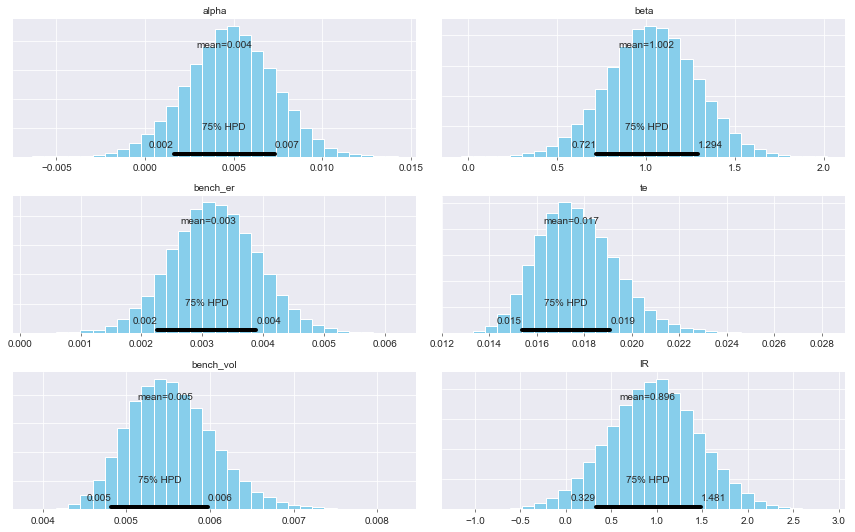

In [438]:
pm.plot_posterior(trace_lr, alpha_level=0.25);

In [439]:
with pm.Model() as model_st:

    alpha = pm.Normal('alpha', mu=0.0, sd=0.025)
    beta = pm.Normal('beta', mu=1, sd=0.25)
    te = pm.HalfCauchy('te', beta=5)
    bench_er = pm.Normal('bench_er', mu=0.003, sd=0.025)
    bench_vol = pm.HalfCauchy('bench_vol', beta=5)

    hf_model = pm.Normal(
        'fund',
        mu=alpha+beta*bench_er,
        sd=te,
        observed=df.iloc[-24:, 1]
    )

    benchmark_model = pm.Normal(
        'benchmark',
        mu=bench_er,
        sd=bench_vol,
        observed=df.iloc[-24:, 0]
    )

    sharpe = pm.Deterministic('IR', (alpha/te)*ann_fac)

    trace_st = pm.sample(10000, tune=1000) # draw posterior samples

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bench_vol, bench_er, te, beta, alpha]
Sampling 4 chains: 100%|██████████| 44000/44000 [00:24<00:00, 1800.93draws/s]


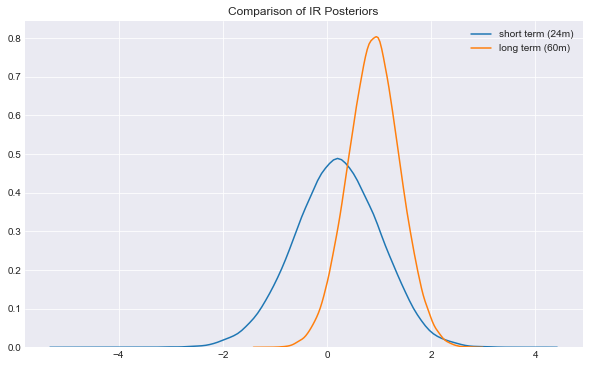

In [442]:
sns.distplot(trace_st['IR'], hist=False, label='short term (24m)');
sns.distplot(trace_lr['IR'], hist=False, label='long term (60m)');
plt.title('Comparison of IR Posteriors');

In [73]:
np.asarray(ppc['returns']).shape

(500, 10)

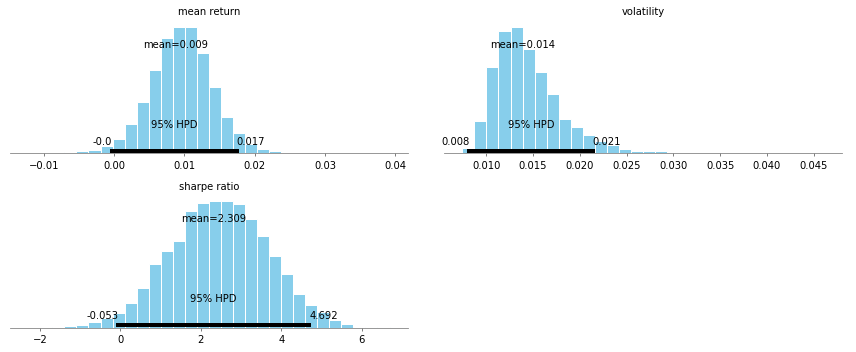

In [7]:
pm.plot_posterior(trace);

In [53]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean return,0.008826,0.004700,0.000110,-0.000302,0.017517,1710.414027,1.001974
volatility,0.014156,0.004078,0.000092,0.007938,0.021920,1560.396967,1.001712
sharpe ratio,2.300204,1.203066,0.023708,-0.165668,4.514961,2374.152903,1.001245


In [49]:
print('P(Sharpe Ratio > 1) = %.2f%%' % (np.mean(trace['sharpe ratio'] > 1) * 100))

P(Sharpe Ratio > 1) = 86.70%


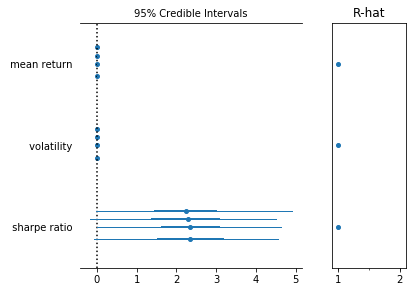

In [50]:
pm.forestplot(trace)

- write programs that generate data like your data
- ML: data --> black box --> preds
- prob programming: clear inference, extreme flexibility; model full uncertainty

- NUTS only handles continuoius variables; if you want discrete add Metroloplis

- Latent causes (parameters); distribution of data; observed data
    - construction model
    - MCMC goes backwards automatically

- Plot posterior which is your belief in that parameter; so the mean is not the hist of returns, but your belief in what the true mean is


In [59]:
# switch is like an if statement in Theano


In [68]:
from pymc3 import Exponential, StudentT, Deterministic, Uniform
from pymc3.distributions.timeseries import GaussianRandomWalk

with pm.Model() as sp500_model:
    nu = Exponential('nu', 1./10, testval=0.10)     # testval is what you initialize with
    sigma = Exponential('sigma', 1./0.02, testval=0.10)
    s = GaussianRandomWalk('s', sigma**-2, shape=n)
    volatility_process = Deterministic('volatility_process', np.exp(-2*s))
    r = StudentT('r', nu, lam=1/volatility_process, observed=returns)

NameError: name 'n' is not defined

In [67]:
from pymc3 import *

with Model() as model:
        # latent causes with priors
        location = Uniform('location', lower=-1, upper=1)
        scale = Uniform('scale', lower=0, upper=1.)
        tail = Uniform('tail', lower=1, upper=20)
        
        # Distribution of data
        obs = StudentT('daily_returns',
                       mu=location,
                       sd=scale,
                       nu=tail,
                       observed=returns_in_sample)  # oberved keyword means will be used to derive params
        
        # compute graph set up and compiled to C by Theano
        
        sampler = NUTS()
        trace = sample(5000, sampler)
        

NameError: name 'returns_in_sample' is not defined

- show a plot of posterior for different history lenghts
```
prob_diff = np.mean(trace[200:]['mean_in_sample'] < trace[200:]['mean_out_of_sample'])
print('P(mean in sample) < mean (OOS) = %.2f%%' % (prob_diff*100))
```

- Variational Inference -- instead of sampling form posterior, fit a dist making assumption. This is very fast
- ELBO -- evidence lower bound; like the objective function




# Bayesian Factor Modeling
